# Model XYZ
 Using aggregated invoice data

Summary here...

In [2]:
import pandas as pd
import numpy as np

import pyarrow
import fastparquet

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt

#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# for saving model to disk
import time
from skops.io import dump, load, get_untrusted_types

## Run data cleaning script, generate parquet files. 
Requires pyarrow and fastparquet (see requirements.txt)

In [3]:
# Open and run **ETL_export_parquet_invoice-level_+_client-level_mean.py**

## Import parquet files

In [3]:
# Import clean data 
# - Each row represents one invoice.
df_train_non_agg = pd.read_parquet("data/df_train_non_agg.parquet")
df_final_test_non_agg = pd.read_parquet("data/df_final_test_non_agg.parquet") # this is not our "test" data, we will still need to perform the test-train split

# Import clean data
# - Each row represents one client. 
# - Invoices are summarised. 
# - The "consommation_level_x" columns show mean energy consumption per client.
df_train_agg = pd.read_parquet("data/df_train_no_dummies_agg_max_consomm.parquet")
df_final_test_agg = pd.read_parquet("data/df_final_test_no_dummies_agg_max_consomm.parquet") # this is not our "test" data, we will still need to perform the test-train split
df_frankenstein = pd.read_parquet("data/df_frankenstein.parquet")

In [12]:
# Choose dataset to use in this document
df = pd.merge(df_train_agg,df_frankenstein, how='left', on='client_id')
df_frankenstein
df_final_test = df_final_test_agg

In [15]:
df.head()

,disrict,client_id,client_catg,region,creation_date,target_x,consommation_level_1_x,consommation_level_2_x,consommation_level_3_x,consommation_level_4_x,...,consommation_level_4_y,counter_type_GAZ,counter_type_ELEC,entries_level_3,level_2_std,level_1_min,level_2_min,level_4_min,target_y,meter_broken
0,60,train_Client_0,11,101,34699,0,1162.0,186.0,0.0,0.0,...,0.000000,False,True,0,10.892234,19.0,0.0,0.0,0.0,0.0
1,69,train_Client_1,11,107,37405,0,732.0,0.0,0.0,0.0,...,0.000000,False,True,0,0.000000,81.5,0.0,0.0,0.0,0.0
2,62,train_Client_10,11,301,31484,0,2212.0,682.0,0.0,0.0,...,0.000000,False,True,0,13.395745,47.0,0.0,0.0,0.0,0.0
3,69,train_Client_100,11,105,35257,0,15.0,0.0,0.0,0.0,...,0.000000,False,True,0,0.000000,0.0,0.0,0.0,0.0,0.0
4,62,train_Client_1000,11,303,41926,0,662.0,400.0,800.0,382.0,...,36.714286,False,True,3,41.788830,62.0,0.0,0.0,0.0,0.0


In [13]:
df_final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54878 entries, 0 to 54877
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   disrict                 54878 non-null  object 
 1   client_id               54878 non-null  object 
 2   client_catg             54878 non-null  object 
 3   region                  54878 non-null  object 
 4   creation_date           54878 non-null  int64  
 5   consommation_level_1_x  53732 non-null  float64
 6   consommation_level_2_x  53732 non-null  float64
 7   consommation_level_3_x  53732 non-null  float64
 8   consommation_level_4_x  53732 non-null  float64
 9   transactions_count      54878 non-null  int64  
 10  tarif_type              54878 non-null  object 
 11  counter_statue          54878 non-null  int32  
 12  counter_code            54878 non-null  object 
 13  reading_remarque        54878 non-null  int32  
 14  counter_coefficient     54878 non-null

In [14]:
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

consommation_level_1_x    2.199689
consommation_level_2_x    2.199689
consommation_level_3_x    2.199689
consommation_level_4_x    2.199689
disrict                   0.000000
consommation_level_2_y    0.000000
target_y                  0.000000
level_4_min               0.000000
level_2_min               0.000000
level_1_min               0.000000
level_2_std               0.000000
entries_level_3           0.000000
counter_type_ELEC         0.000000
counter_type_GAZ          0.000000
consommation_level_4_y    0.000000
consommation_level_3_y    0.000000
reading_remarque          0.000000
consommation_level_1_y    0.000000
counter_coefficient       0.000000
client_id                 0.000000
counter_code              0.000000
counter_statue            0.000000
tarif_type                0.000000
transactions_count        0.000000
target_x                  0.000000
creation_date             0.000000
region                    0.000000
client_catg               0.000000
meter_broken        

In [16]:
df.drop(['client_id','consommation_level_1_x','consommation_level_2_x','consommation_level_3_x','consommation_level_4_x', 'target_y'], axis=1, inplace=True)
df_final_test.drop(['client_id','consommation_level_1_x','consommation_level_2_x','consommation_level_3_x','consommation_level_4_x'], axis=1, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128000 entries, 0 to 127999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   disrict                 128000 non-null  object 
 1   client_catg             128000 non-null  object 
 2   region                  128000 non-null  object 
 3   creation_date           128000 non-null  int64  
 4   target_x                128000 non-null  int32  
 5   transactions_count      128000 non-null  int64  
 6   tarif_type              128000 non-null  object 
 7   counter_statue          128000 non-null  int32  
 8   counter_code            128000 non-null  object 
 9   reading_remarque        128000 non-null  int32  
 10  counter_coefficient     128000 non-null  float64
 11  consommation_level_1_y  128000 non-null  float64
 12  consommation_level_2_y  128000 non-null  float64
 13  consommation_level_3_y  128000 non-null  float64
 14  consommation_level_4

## Split Data to Train and Test

In [18]:
# Make sure final_test has same dummy columns in as training data (filled with False)
def add_missing_dummy_columns_and_fill_false(train, final_test): 

    cols_missing_from_final_test = (set(train) - set(final_test)) - set(['target'])

    for cols in cols_missing_from_final_test:   
        final_test[cols] = False
    print(f"Adding new cols to final_test: {cols_missing_from_final_test}")

add_missing_dummy_columns_and_fill_false(df, df_final_test)

Adding new cols to final_test: {'level_4_min', 'level_2_min', 'target_x', 'level_2_std', 'meter_broken', 'level_1_min', 'entries_level_3'}


In [20]:
X = df.loc[:, ~df.columns.isin(["target_x"])]
y = df["target_x"]
X_final_test = df_final_test

# make sure column order the same in X and X_final_test
X, X_final_test = X.align(X_final_test, join="right", axis=1)

RSEED = 42

# 30% examples in test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=RSEED
)


## Imputing missing values

In [21]:
# % of missing values for each column in Training data
(100 * df.isnull().sum() / df.count()).sort_values(ascending=False)

disrict                   0.0
consommation_level_2_y    0.0
level_4_min               0.0
level_2_min               0.0
level_1_min               0.0
level_2_std               0.0
entries_level_3           0.0
counter_type_ELEC         0.0
counter_type_GAZ          0.0
consommation_level_4_y    0.0
consommation_level_3_y    0.0
consommation_level_1_y    0.0
client_catg               0.0
counter_coefficient       0.0
reading_remarque          0.0
counter_code              0.0
counter_statue            0.0
tarif_type                0.0
transactions_count        0.0
target_x                  0.0
creation_date             0.0
region                    0.0
meter_broken              0.0
dtype: float64

In [22]:
# % of missing values for each column in the final test data. Compare with training data above to see if similar proportion.
(100 * df_final_test.isnull().sum() / df_final_test.count()).sort_values(ascending=False)

disrict                   0.0
consommation_level_3_y    0.0
level_1_min               0.0
meter_broken              0.0
level_2_std               0.0
target_x                  0.0
level_2_min               0.0
level_4_min               0.0
counter_type_ELEC         0.0
counter_type_GAZ          0.0
consommation_level_4_y    0.0
consommation_level_2_y    0.0
client_catg               0.0
consommation_level_1_y    0.0
counter_coefficient       0.0
reading_remarque          0.0
counter_code              0.0
counter_statue            0.0
tarif_type                0.0
transactions_count        0.0
creation_date             0.0
region                    0.0
entries_level_3           0.0
dtype: float64

In [23]:
# What does the data look like for rows with missing data
df_missing_values = df[pd.isnull(df["transactions_count"]) == True]

In [ ]:
X_train.drop(['target_x'], axis=1, inplace=True)
X_train.isnull().sum().sort_values(ascending = False)


disrict                   0
client_catg               0
level_1_min               0
meter_broken              0
level_2_std               0
level_2_min               0
level_4_min               0
counter_type_ELEC         0
counter_type_GAZ          0
consommation_level_4_y    0
consommation_level_3_y    0
consommation_level_2_y    0
consommation_level_1_y    0
counter_coefficient       0
reading_remarque          0
counter_code              0
counter_statue            0
tarif_type                0
transactions_count        0
creation_date             0
region                    0
entries_level_3           0
dtype: int64

In [29]:
X_test.drop(['target_x'], axis=1, inplace=True)
X_test.isnull().sum().sort_values(ascending = False)

disrict                   0
client_catg               0
level_1_min               0
meter_broken              0
level_2_std               0
level_2_min               0
level_4_min               0
counter_type_ELEC         0
counter_type_GAZ          0
consommation_level_4_y    0
consommation_level_3_y    0
consommation_level_2_y    0
consommation_level_1_y    0
counter_coefficient       0
reading_remarque          0
counter_code              0
counter_statue            0
tarif_type                0
transactions_count        0
creation_date             0
region                    0
entries_level_3           0
dtype: int64

In [32]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 38400 entries, 103988 to 21534
Series name: target_x
Non-Null Count  Dtype
--------------  -----
38400 non-null  int32
dtypes: int32(1)
memory usage: 450.0 KB


In [33]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train,y_train)

In [34]:
# Convert boolean columns to integers
X_train_resampled["counter_type_GAZ"] = X_train_resampled["counter_type_GAZ"].astype(int)
X_train_resampled["counter_type_ELEC"] = X_train_resampled["counter_type_ELEC"].astype(int)

X_test["counter_type_GAZ"] = X_test["counter_type_GAZ"].astype(int)
X_test["counter_type_ELEC"] = X_test["counter_type_ELEC"].astype(int)

In [35]:
X_train_resampled.info()

 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168614 entries, 0 to 168613
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   disrict                 168614 non-null  object 
 1   client_catg             168614 non-null  object 
 2   region                  168614 non-null  object 
 3   creation_date           168614 non-null  int64  
 4   transactions_count      168614 non-null  int64  
 5   tarif_type              168614 non-null  object 
 6   counter_statue          168614 non-null  int32  
 7   counter_code            168614 non-null  object 
 8   reading_remarque        168614 non-null  int32  
 9   counter_coefficient     168614 non-null  float64
 10  consommation_level_1_y  168614 non-null  float64
 11  consommation_level_2_y  168614 non-null  float64
 12  consommation_level_3_y  168614 non-null  float64
 13  consommation_level_4_y  168614 non-null  float64
 14  counter_type_GAZ    

In [36]:
# Pipeline

cat_features = ["disrict",
        "client_catg",
        "region",
        "tarif_type",
        "reading_remarque",
        "counter_statue",
        "counter_code",
        "counter_type_GAZ",
        "counter_type_ELEC"
        ]
num_features = ["creation_date",
        "transactions_count",
        "counter_coefficient",
        "consommation_level_1_y",
        "consommation_level_2_y",
        "consommation_level_3_y",
        "consommation_level_4_y",
        "level_4_min",
        "level_2_min",
        "level_2_std",
        "meter_broken",
        "level_1_min",
        "entries_level_3"
            ]

from sklearn.pipeline import Pipeline

# Pipeline for numerical features
# Initiating Pipeline and calling one step after another
# each step is built as a list of (key, value)
# key is the name of the processing step
# value is an estimator object (processing step)
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')), # replace 0s with means 
   # ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
   # ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

from sklearn.compose import ColumnTransformer

# Complete pipeline for numerical and categorical features
# 'ColumnTransformer' applies transformers (num_pipeline/ cat_pipeline)
# to specific columns of an array or DataFrame (num_features/cat_features)
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Train Model

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Define categorical and numerical features
cat_features = [
    "disrict",
    "client_catg",
    "region",
    "tarif_type",
    "reading_remarque",
    "counter_statue",
    "counter_code",
    "counter_type_GAZ",
    "counter_type_ELEC"
]
num_features = [
    "creation_date",
    "transactions_count",
    "counter_coefficient",
    "consommation_level_1_y",
    "consommation_level_2_y",
    "consommation_level_3_y",
    "consommation_level_4_y",
    "level_4_min",
    "level_2_min",
    "level_2_std",
    "meter_broken",
    "level_1_min",
    "entries_level_3"
]

# Preprocess categorical features
cat_imputer = SimpleImputer(strategy="constant", fill_value="missing")
X_train_resampled[cat_features] = cat_imputer.fit_transform(X_train_resampled[cat_features])
X_test[cat_features] = cat_imputer.transform(X_test[cat_features])

# Convert categorical features to strings
for col in cat_features:
    X_train_resampled[col] = X_train_resampled[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Preprocess numerical features
num_imputer = SimpleImputer(strategy="mean")
X_train_resampled[num_features] = num_imputer.fit_transform(X_train_resampled[num_features])
X_test[num_features] = num_imputer.transform(X_test[num_features])

# Combine preprocessed data
X_train_preprocessed = X_train_resampled
X_test_preprocessed = X_test

# Initialize CatBoostClassifier
catboost_model = CatBoostClassifier(cat_features=cat_features, verbose=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'iterations': [300, 500, 700],  # Number of boosting iterations
    'depth': [6, 8, 10],  # Depth of the trees
    'learning_rate': [0.2, 0.3, 0.4],  # Learning rate
    'l2_leaf_reg': [1],  # L2 regularization
    'class_weights': [None, [2, 23]]  # Class weights for imbalanced data
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    catboost_model,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='f1',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print progress
)

# Fit GridSearchCV
grid_search.fit(X_train_preprocessed, y_train_resampled)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
y_train_predict = best_model.predict(X_train_preprocessed)
y_test_predict = best_model.predict(X_test_preprocessed)

timestamp_for_filename = time.strftime("%Y-%m_%d_%H%M%S")
model_name = "example_model"

filepath = f"./models/{model_name} {timestamp_for_filename}.skops"

obj = dump(best_model, filepath)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\MaxTs\neuefische\Projects\ds-fraud-detection\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\MaxTs\neuefische\Projects\ds-fraud-detection\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\MaxTs\neuefische\Projects\ds-fraud-detection\.venv\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None,

Best Parameters: {'class_weights': [2, 23], 'depth': 10, 'iterations': 700, 'l2_leaf_reg': 1, 'learning_rate': 0.4}
Best F1 Score: 0.9240758139069353


Best Parameters: {'class_weights': [1, 3], 'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.2}

Best F1 Score: 0.8473158834235063

## Metrics for Best Model

Accuracy: 0.96
Precision: 0.92
Recall: 1.00
F1 Score: 0.96


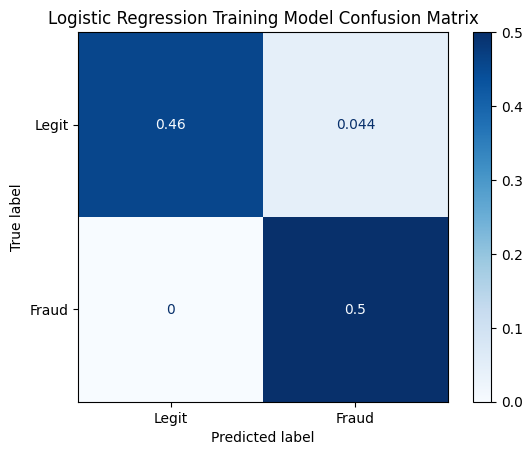

In [44]:
# Calculate metrics
accuracy = accuracy_score(y_train_resampled, y_train_predict)
precision = precision_score(y_train_resampled, y_train_predict)
recall = recall_score(y_train_resampled, y_train_predict)
f1 = f1_score(y_train_resampled, y_train_predict)


# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Generate the confusion matrix
cm = confusion_matrix(y_train_resampled, y_train_predict, normalize='all')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Logistic Regression Training Model Confusion Matrix')
plt.show()

Accuracy: 0.83
Precision: 0.13
Recall: 0.35
F1 Score: 0.19


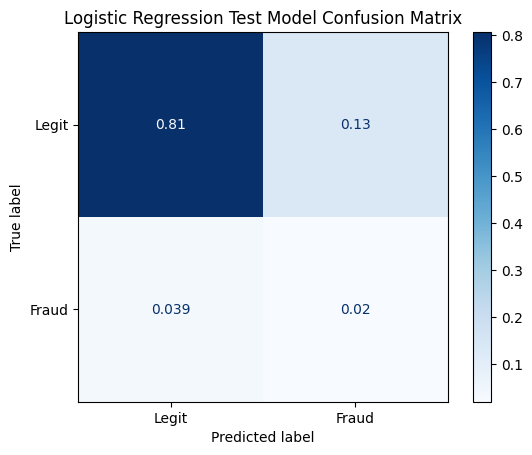

In [45]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict)
recall = recall_score(y_test, y_test_predict)
f1 = f1_score(y_test, y_test_predict)


# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_predict, normalize='all')

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Logistic Regression Test Model Confusion Matrix')
plt.show()

# Save best model for future use

 https://scikit-learn.org/stable/model_persistence.html#skops-persistence


